In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from entropy_bounds.utils import optimization_cf
from binaryIV import simulate_deterministic_data_with_probabilistic_ate, extract_prob_dict, entropy_of_array
from entropy_bounds.entropy_bounds import compute_ate_bounds

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf


pd.options.mode.chained_assignment = None  # default='warn'


pd.set_option('display.max_columns', None)

from autobound.causalProblem import causalProblem
from autobound.DAG import DAG
import io


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = pd.read_pickle('binaryIV_results.pkl')

In [7]:
def compute_joint_probabilities(df):
    """
    Computes the joint probabilities for each combination of Z, X, and Y in the input DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame with columns ['X', 'Y', 'Z'].

    Returns:
        pd.DataFrame: DataFrame with columns ['Z', 'X', 'Y', 'prob'] representing the joint probabilities.
    """
    # Count occurrences of each combination of Z, X, Y
    joint_counts = df.groupby(['Z', 'X', 'Y']).size().reset_index(name='count')
    
    # Calculate total number of rows in the input DataFrame
    total_count = len(df)
    
    # Compute probabilities
    joint_counts['prob'] = joint_counts['count'] / total_count
    
    # Drop the count column as it's not needed in the output
    joint_probs = joint_counts.drop(columns=['count'])
    
    return joint_probs

# Example usage
input_df = pd.DataFrame({
    'X': [1, 1, 0, 0, 0],
    'Y': [0, 0, 1, 0, 0],
    'Z': [0, 1, 1, 1, 0]
})

result = compute_joint_probabilities(input_df)
print(result)

   Z  X  Y  prob
0  0  0  0   0.2
1  0  1  0   0.2
2  1  0  0   0.2
3  1  0  1   0.2
4  1  1  0   0.2


In [18]:
def plot_smoothed_ate_vs_bounds(dataframe, window=1):
    """
    Plot smoothed ATE_true and 2SLS confidence intervals from the given dataframe.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing columns 'ATE_true', '2SLS_CI_lower', '2SLS_CI_upper', and 'b_X_Y'.
    window (int): The size of the rolling window for smoothing. Default is 1.

    Returns:
    None
    """
    # Smoothen the data using a rolling average
    dataframe['ATE_true_smooth'] = dataframe['ATE_true'].rolling(window=window, center=True).mean()
    dataframe['autobound_bound_lower_smooth'] = dataframe['autobound_bound_lower'].rolling(window=window, center=True).mean()
    dataframe['autobound_bound_upper_smooth'] = dataframe['autobound_bound_upper'].rolling(window=window, center=True).mean()

    # Plot the smoothed data
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=dataframe, x='b_X_Y', y='ATE_true_smooth', label='$ATE_{true}$', color='blue')
    sns.lineplot(data=dataframe, x='b_X_Y', y='autobound_bound_lower_smooth', label='Lower Bound', color='orange')
    sns.lineplot(data=dataframe, x='b_X_Y', y='autobound_bound_upper_smooth', label='Upper Bound', color='green')
    plt.axhline(0, color='red', linestyle='--', label='Zero Line')
    plt.title('autobounds vs $ATE_{true}$ (smoothed out)')
    plt.xlabel('b_X_Y Coefficient')
    plt.ylabel('ATE Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
# Minimal working example
sim = data.iloc[0]
df = pd.DataFrame({'X': sim['X'], 'Y': sim['Y'], 'Z': sim['Z']})
joint_probs = compute_joint_probabilities(df)

dag = DAG()
dag.from_structure("Z -> X, X -> Y, U -> X, U -> Y", unob = "U")

problem = causalProblem(dag)
problem.load_data_pandas(joint_probs)
problem.add_prob_constraints()
problem.set_ate(ind='X', dep='Y')

program = problem.write_program()
lb, ub = program.run_pyomo(solver_name='glpk', verbose=False)

print("Lower Bound:", lb)
print("Upper Bound:", ub)
print("True ATE:", sim['ATE_true'])



Lower Bound: -0.80952380952381
Upper Bound: 0.156682027649769
True ATE: -0.6494981193401556


In [14]:
df_results = data.copy()
for idx, sim in df_results.iterrows():
    df = pd.DataFrame({'X': sim['X'], 'Y': sim['Y'], 'Z': sim['Z']})
    joint_probs = compute_joint_probabilities(df)

    dag = DAG()
    dag.from_structure("Z -> X, X -> Y, U -> X, U -> Y", unob = "U")

    problem = causalProblem(dag)
    problem.load_data_pandas(joint_probs)
    problem.add_prob_constraints()
    problem.set_ate(ind='X', dep='Y')

    program = problem.write_program()
    lb, ub = program.run_pyomo(solver_name='glpk', verbose=False)
    # Check if true ATE is within bounds
    bounds_valid = lb <= sim['ATE_true'] <= ub

    df_results.at[idx, 'autobound_bound_lower'] = lb
    df_results.at[idx, 'autobound_bound_upper'] = ub
    df_results.at[idx, 'autobound_bound_width'] = ub - lb
    df_results.at[idx, 'autobound_bounds_valid'] = bounds_valid



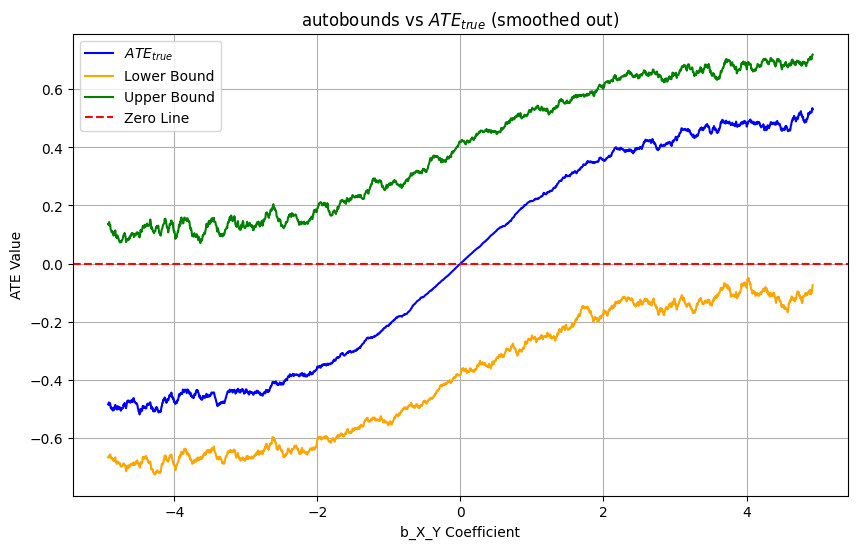

Avg bounds width: 0.7914459855922237


In [ ]:
plot_smoothed_ate_vs_bounds(df_results, window=30)

In [24]:
print('Avg bounds width:', df_results['autobound_bound_width'].mean())
print('# invalid:', df_results[df_results['autobound_bounds_valid'] == False].shape[0])

Avg bounds width: 0.7914459855922237
# invalid: 0


Autobound Claims to have tightestest bounds:


In [13]:
causaloptim_tighter = data.iloc[1]
# autobound_bound_lower     -0.663114
# autobound_bound_upper      0.109372
# autobound_bound_width      0.772486
# causaloptim_bound_lower   -0.663114
# causaloptim_bound_upper   -0.014916
# causaloptim_bound_width    0.648198


# Minimal working example
sim = causaloptim_tighter
df = pd.DataFrame({'X': sim['X'], 'Y': sim['Y'], 'Z': sim['Z']})
joint_probs = compute_joint_probabilities(df)

dag = DAG()
dag.from_structure("Z -> X, X -> Y, U -> X, U -> Y", unob = "U")

problem = causalProblem(dag)
problem.load_data_pandas(joint_probs)
problem.add_prob_constraints()
problem.set_ate(ind='X', dep='Y')

program = problem.write_program()
lb, ub = program.run_pyomo(solver_name='glpk', verbose=True)

print("Lower Bound:", lb)
print("Upper Bound:", ub)
print("True ATE:", sim['ATE_true'])






GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\tmari\AppData\Local\Temp\tmpg_zhb2sc.glpk.raw --wglp C:\Users\tmari\AppData\Local\Temp\tmpgp4tmvar.glpk.glp
 --cpxlp C:\Users\tmari\AppData\Local\Temp\tmp_7gfnndi.pyomo.lp
Reading problem data from 'C:\Users\tmari\AppData\Local\Temp\tmp_7gfnndi.pyomo.lp'...
10 rows, 17 columns, 57 non-zeros
114 lines were read
Writing problem data to 'C:\Users\tmari\AppData\Local\Temp\tmpgp4tmvar.glpk.glp'...
114 lines were written
GLPK Simplex Optimizer 5.0
10 rows, 17 columns, 57 non-zeros
Preprocessing...
10 rows, 16 columns, 56 non-zeros
Scaling...
 A: min|aij| =  4.920e-01  max|aij| =  1.000e+00  ratio =  2.033e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7
      0: obj =   1.405159721e-02 inf =   9.202e-01 (3)
      4: obj =  -6.549836758e-01 inf =   9.541e-17 (0)
*     7: obj =   1.093719992e-01 inf =   9.541e-17 (0)
OPTIMAL LP SOLUTION FOUND
Time used: